## feature based method (HoG)

> Add blockquote



In [ ]:
!tar -xf /content/metal_nut.tar.xz -C /content/

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern, hog

In [ ]:
# ------------------------------
# 1. Load & visualize sample images
# ------------------------------

def visualize_images(images, title):
  # Visualize some images
  plt.figure(figsize=(8,4))
  for i, path in enumerate(images[:4]):
      img = cv2.imread(path) # load in color (BGR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB for matplotlib
      print(img.shape)
      plt.subplot(1,4,i+1)
      plt.imshow(img)  # no cmap needed
      plt.axis("off")

  plt.suptitle(title)
  plt.show()

(700, 700, 3)
(700, 700, 3)
(700, 700, 3)
(700, 700, 3)


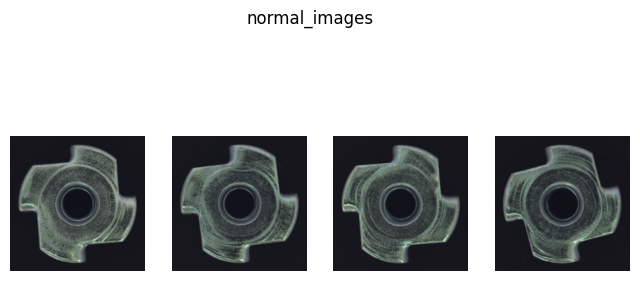

In [ ]:
import glob
normal_images = glob.glob("/content/metal_nut/train/good/*.png") # extract pathnames with specific pattern
visualize_images(normal_images, title = "normal_images")

(700, 700, 3)
(700, 700, 3)
(700, 700, 3)
(700, 700, 3)


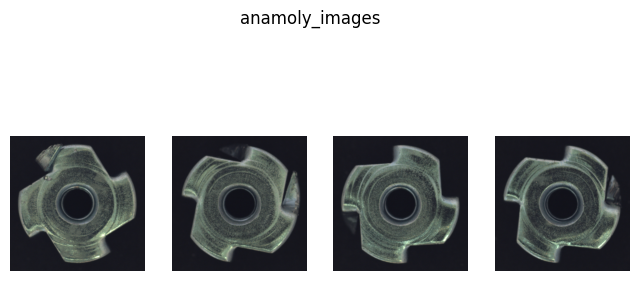

In [ ]:
import glob
anamoly_images = glob.glob("/content/metal_nut/test/bent/*.png") # extract pathnames with specific pattern
visualize_images(anamoly_images, title = "anamoly_images")

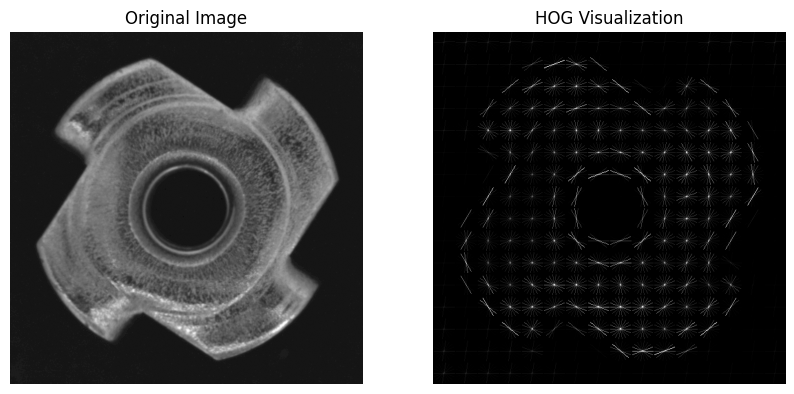

HOG feature vector length: 8100


In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# Load image in grayscale
img = cv2.imread("/content/metal_nut/train/good/000.png", cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (512,512))

# Compute HOG features
hog_features, hog_image = hog(
    img_resized,
    orientations=9,
    pixels_per_cell=(32, 32),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True
)

# Rescale for better contrast
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Plot original and HOG
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(hog_image_rescaled, cmap="gray")
plt.title("HOG Visualization")
plt.axis("off")

plt.show()

print("HOG feature vector length:", len(hog_features))


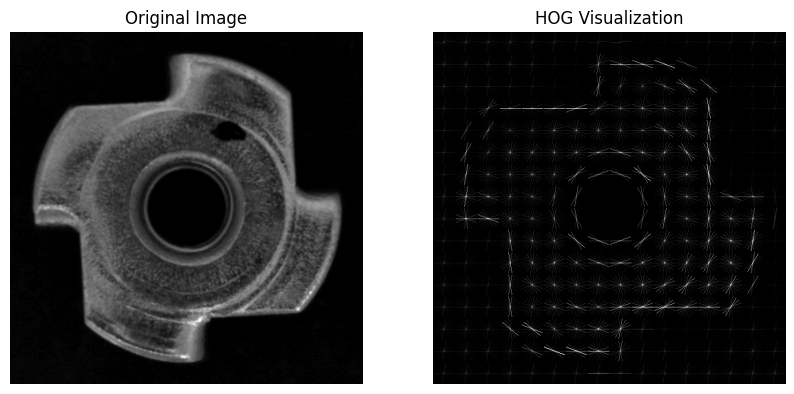

HOG feature vector length: 8100


In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# Load image in grayscale
img = cv2.imread("/content/metal_nut/test/color/000.png", cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (512,512))

# Compute HOG features
hog_features, hog_image = hog(
    img_resized,
    orientations=9,
    pixels_per_cell=(32, 32),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True
)

# Rescale for better contrast
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Plot original and HOG
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(hog_image_rescaled, cmap="gray")
plt.title("HOG Visualization")
plt.axis("off")

plt.show()

print("HOG feature vector length:", len(hog_features))


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
import glob

# ------------------------------
# 3. HOG Features
# ------------------------------
def extract_hog(img):
    """
    img: grayscale image
    returns: HOG feature vector
    """
    hog_features, _ = hog(img, orientations=9, pixels_per_cell=(8,8),
                          cells_per_block=(2,2), visualize=True, block_norm='L2-Hys')
    return hog_features

# ------------------------------
# 4. Combined Feature Extraction
# ------------------------------
def extract_features(img):
    """
    img: input grayscale image
    returns: combined feature vector (LBP + Gabor + HOG)
    """
    img_resized = cv2.resize(img, (64,128))
    hog = extract_hog(img_resized)
    return hog


In [ ]:
# Example: assuming folder structure
normal_paths = glob.glob("/content/metal_nut/train/good/*.png")
anomaly_paths = glob.glob("/content/metal_nut/test/scratch/*.png")

X_train, X_test, y_test = [], [], []

# Train on normal images only
for path in normal_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    X_train.append(extract_features(img))
X_train = np.array(X_train)

# Test set: mixed normal + anomaly
test_paths = glob.glob("/content/metal_nut/test/good/*.png")
for path in test_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    X_test.append(extract_features(img))
    y_test.append(0)

for path in anomaly_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    X_test.append(extract_features(img))
    y_test.append(1)

X_test = np.array(X_test)
y_test = np.array(y_test)


In [ ]:
import numpy as np

# Assuming X_test and y_test are numpy arrays
indices = np.arange(len(X_test))
np.random.shuffle(indices)

X_test = X_test[indices]
y_test = y_test[indices]


In [ ]:
print(X_train.shape)
print(X_test.shape)

(220, 3780)
(45, 3780)


In [ ]:
print(type(y_test))

<class 'numpy.ndarray'>


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc
import glob

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)  # nu = expected anomaly fraction
ocsvm.fit(X_train_scaled)

# Use decision function for ROC
scores = -ocsvm.decision_function(X_test_scaled )  # higher = more anomalous
y_pred = ocsvm.predict(X_test_scaled)

In [ ]:
print(y_pred)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
print(y_test)

[1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1
 0 1 1 0 0 0 1 1]


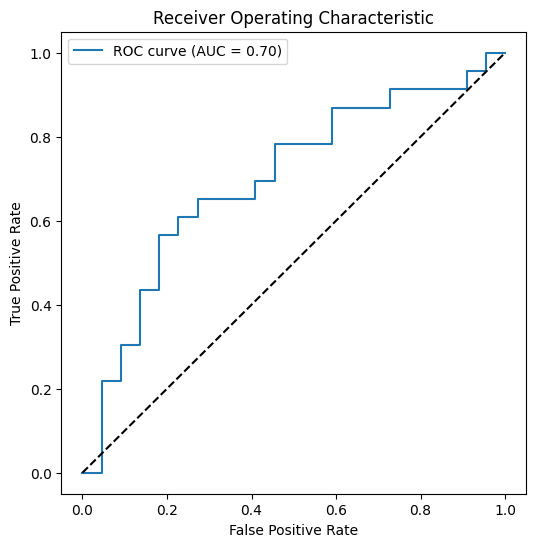

In [ ]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()


In [ ]:
scores = -ocsvm.decision_function(X_test_scaled)
# higher = more anomalous

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, scores)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]


In [ ]:
y_pred = (scores > optimal_threshold).astype(int)

In [ ]:
print(y_pred)

[1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0
 0 0 0 0 0 0 1 1]


In [ ]:
print(y_test)

[1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1
 0 1 1 0 0 0 1 1]
